In [71]:
!unzip thread.zip

Archive:  thread.zip
  inflating: threads_reviews.csv     


## Import Library

In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [73]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Import Dataset

In [74]:
df = pd.read_csv('threads_reviews.csv')
df.head()

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


## Menghapus tanda baca pada teks

In [75]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

df["review_description"] = df["review_description"].apply(remove_punctuation)

## Menghapus konjungsi atau kata tambahan yang tidak perlu

In [76]:
NUM_WORDS = 1300

stop_words = set(stopwords.words("english"))

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="x", split=" ")
tokenizer.fit_on_texts(df["review_description"].astype(str))

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

df["review_description"] = df["review_description"].apply(preprocess_text)


## Melakukan encoding pada kolom "source"

In [77]:
le = LabelEncoder()
df["source"] = le.fit_transform(df["source"])
df.head()

,source,review_description,rating,review_date
0,1,Meh greatest experience Chromebook Seems custo...,2,2023-07-08 14:18:24
1,1,Pretty good first launch easy use selfexplanat...,3,2023-07-19 20:52:48
2,1,brand new app well optimized However missing q...,3,2023-07-06 23:03:11
3,1,Great app lot potential However lot needs fixe...,3,2023-07-10 00:53:25
4,1,app good needs lot functionality example searc...,3,2023-07-06 16:57:43


## Data Splitting

In [78]:
X = df["review_description"]
y = df["source"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tokenizing & Sequencing

In [79]:
MAXLEN = 100

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(
    X_train_sequences,
    maxlen=MAXLEN,
    padding="post",
    truncating="post"
)

X_test_padded = pad_sequences(
    X_test_sequences,
    maxlen=MAXLEN,
    padding="post",
    truncating="post"
)

## Modelling

In [80]:
all_words = set()
for i in pd.concat([X_train, X_test]).astype(str).tolist():
    for j in i.split():
        all_words.add(j)

NUM_WORDS = len(all_words) + 1

In [83]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, output_dim=MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.GaussianDropout(0.1),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.build(input_shape=(None, MAXLEN))
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 100)            │       2,753,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_24 (Bidirectional)     │ (None, 100, 512)            │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_25 (Bidirectional)     │ (None, 100, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_26 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_dropout_8 (GaussianDropout) │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,315,741 (16.46 MB)

 Trainable params: 4,315,741 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.01,
        clipvalue=0.5,
    ),
    metrics=["accuracy"]
)

## Membuat EarlyStopping Callback

In [85]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    verbose=1,
    restore_best_weights=True
)

## Training Model

In [86]:
history = model.fit(
    X_train_padded,
    y_train,
    epochs=30,
    validation_data=(X_test_padded, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
823/823 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.9139 - loss: 0.2760 - val_accuracy: 0.9158 - val_loss: 0.2714
Epoch 2/30
823/823 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.9227 - loss: 0.2250 - val_accuracy: 0.9184 - val_loss: 0.2408
Epoch 3/30
823/823 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.9250 - loss: 0.2019 - val_accuracy: 0.9187 - val_loss: 0.2171
Epoch 4/30
823/823 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - accuracy: 0.9234 - loss: 0.2015 - val_accuracy: 0.9186 - val_loss: 0.2299
Epoch 5/30
823/823 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.9246 - loss: 0.1920 - val_accuracy: 0.9224 - val_loss: 0.2096
Epoch 6/30
823/823 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9303 - loss: 0.1927 - val_accuracy: 0.9190 - val_loss: 0.2181
Epoch 7/30
823/823 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9298 - loss: 0.1836 - val_accuracy: 0.9263 - val_loss: 0.2529
Epoch 8/30
823/823 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9360 - loss: 0.1788 - 

## Evaluasi Model

In [87]:
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

y_pred_classes = y_pred_classes.flatten()

accuracy = np.mean(y_pred_classes == y_test)
print("Accuracy:", accuracy)

206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Accuracy: 0.9263141902157399


In [88]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, output_dict=True, zero_division=1)
df_report = pd.DataFrame(report).transpose()

def highlight(val):
    return 'background-color: black; color: white'

styled_df = df_report.style.map(highlight)

display(styled_df)

,precision,recall,f1-score,support
0,0.730263,0.200000,0.314003,555.000000
1,0.930949,0.993197,0.961066,6027.000000
accuracy,0.926314,0.926314,0.926314,0.926314
macro avg,0.830606,0.596599,0.637534,6582.000000
weighted avg,0.914027,0.926314,0.906505,6582.000000


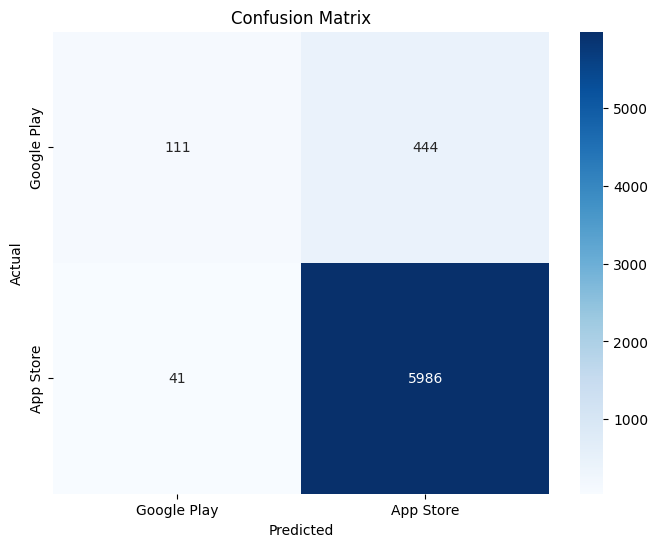

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Google Play", "App Store"],
            yticklabels=["Google Play", "App Store"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


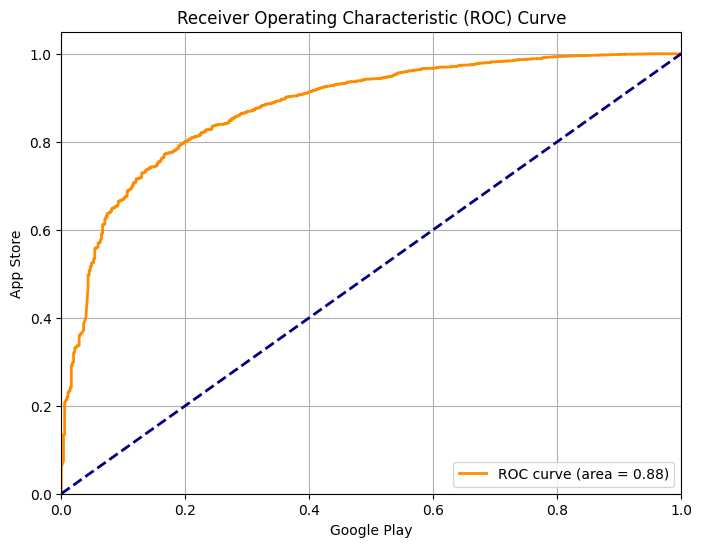

In [92]:
y_pred_proba = model.predict(X_test_padded)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Google Play')
plt.ylabel('App Store')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

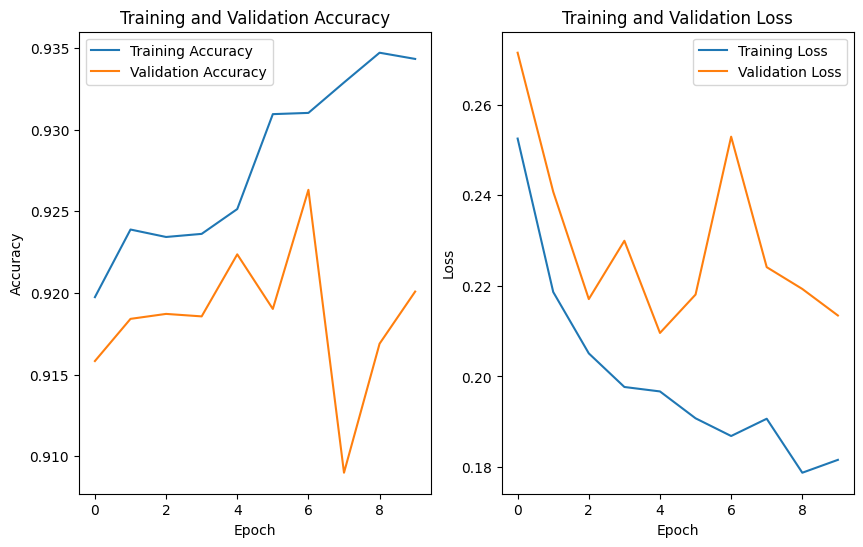

In [93]:
  plt.figure(figsize=(10, 6))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()